# Cardiovascular Disease dataset

https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

Descrição dos Dados
Existem 3 tipos de características de entrada:

- Objetivo: informações factuais;
- Exame: resultados do exame médico;
- Subjetivo: informações fornecidas pelo paciente.

Colunas:

1. Idade | Característica Objetiva | age | int (dias);
2. Altura | Característica Objetiva | height | int (cm);
3. Peso | Característica Objetiva | weight | float (kg);
4. Gênero | Característica Objetiva | gender | código categórico;
5. Pressão arterial sistólica | Característica do Exame | ap_hi | int;
6. Pressão arterial diastólica | Característica do Exame | ap_lo | int;
7. Colesterol | Característica do Exame | cholesterol | 1: normal, 2: acima do normal, 3: bem acima do normal;
8. Glicose | Característica do Exame | gluc | 1: normal, 2: acima do normal, 3: bem acima do normal;
9. Fumar | Característica Subjetiva | smoke | binário;
10. Consumo de álcool | Característica Subjetiva | alco | binário;
11. Atividade física | Característica Subjetiva | active | binário;
12. Presença ou ausência de doença cardiovascular | Variável Alvo | cardio | binário.

Todos os valores do conjunto de dados foram coletados no momento do exame médico.

In [1]:
# Importando bibliotecas 

import numpy as np
import pandas as pd
import shap
import plotly
import fasttreeshap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

from PIL import Image
from IPython.display import display

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando na memória os respectivos dataframes e adicionando um argumento para corrigir as colunas "Unnamed: 0"
df_cardio = pd.read_csv("/home/formiga/Desktop/Cardio/cardio.csv", sep=";")

In [3]:
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
# Deletando a coluna id
del df_cardio["id"]

# Transformando a idade (dias) em anos
df_cardio["age"] = round(df_cardio["age"] / 365,1)

# Convertendo idade e peso para números inteiros
df_cardio["age"] = df_cardio["age"].astype(int)
df_cardio["weight"] = df_cardio["weight"].astype(int)

# Analisando algumas informações sobre as colunas do dataset
df_cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          70000 non-null  int64
 1   gender       70000 non-null  int64
 2   height       70000 non-null  int64
 3   weight       70000 non-null  int64
 4   ap_hi        70000 non-null  int64
 5   ap_lo        70000 non-null  int64
 6   cholesterol  70000 non-null  int64
 7   gluc         70000 non-null  int64
 8   smoke        70000 non-null  int64
 9   alco         70000 non-null  int64
 10  active       70000 non-null  int64
 11  cardio       70000 non-null  int64
dtypes: int64(12)
memory usage: 6.4 MB


In [5]:
# Renomeando as colunas para português para melhor entendimento ao realizar os gráficos
df_cardio = df_cardio.rename(columns={'age': 'idade', 
                                    'gender': 'sexo', 
                                    'height': 'altura', 
                                    'weight': 'peso',
                                    'ap_hi': 'PAS', 
                                    'ap_lo': 'PAD', 
                                    'cholesterol': 'colesterol', 
                                    'gluc': 'glicose', 
                                    'smoke': 'fumante', 
                                    'alco': 'alcool',
                                    'active': 'ativo'
                                   })

In [6]:
# Utilizando o ydata_profiling para analisar todas as colunas de forma detalhada e com pouco código
from ydata_profiling import ProfileReport
profile = ProfileReport(df_cardio, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Apesar de haver algumas linhas duplicadas (3,3% do dataset), isso é algo normal, dado a pouca quantidade de colunas e as váriaveis que poderiam haver diferenças (colesterol e glicose) são variáveis categóricas.

### Realizando algumas transformações

In [7]:
# Dado que há números negativos nas pressões(provavelmente foram digitados de forma errada, vamos utilizar a função de módulo para torná-los positivos
df_cardio.PAS = abs(df_cardio.PAS)
df_cardio.PAD = abs(df_cardio.PAD)

# Removendo pacientes com menos de 40kg 
df_cardio = df_cardio[(df_cardio.peso >= 40)]

# Removendo pressões extremas
df_cardio = df_cardio[(df_cardio.PAS >= 60) & (df_cardio.PAS <= 300)]
df_cardio = df_cardio[(df_cardio.PAD >= 40) & (df_cardio.PAD <= 150)]

print("O comprimento total do dataset após essas alterações é de", len(df_cardio), "linhas")

O comprimento total do dataset após essas alterações é de 68713 linhas


In [8]:
# Separando as colunas indicadoras da coluna alvo (cardio)
Y = df_cardio["cardio"]
X = df_cardio.loc[:, df_cardio.columns != "cardio"]

In [9]:
X

,idade,sexo,altura,peso,PAS,PAD,colesterol,glicose,fumante,alcool,ativo
0,50,2,168,62,110,80,1,1,0,0,1
1,55,1,156,85,140,90,3,1,0,0,1
2,51,1,165,64,130,70,3,1,0,0,0
3,48,2,169,82,150,100,1,1,0,0,1
4,47,1,156,56,100,60,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,52,2,168,76,120,80,1,1,1,0,1
69996,61,1,158,126,140,90,2,2,0,0,1
69997,52,2,183,105,180,90,3,1,0,1,0
69998,61,1,163,72,135,80,1,2,0,0,0


In [10]:
# Separando o dataset em treino (80%) de teste (20%) de forma aleatória
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=10)

In [11]:
# Utilizando o algoritmo de Machine Learning Random Forest e realizando o fit dos dados para não haver muita divergência entre as colunas
ml_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=4) # (n_estimators= quantidade de árvores, n_jobs= quantidade de núcleos da CPU, max_depth= profundidade dos galhos/folhas, )
ml_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_jobs=-1)

In [12]:
# Confirmando que a predição é de apenas uma coluna
ml_model.predict(x_test.iloc[0].values.reshape(1, -1))

array([1])

In [13]:
y_test.iloc[0]

0

In [14]:
predictions = ml_model.predict(x_test)

In [15]:
# Hora de imprimir a precisão do modelo
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       329
           1       0.78      0.65      0.71       359

    accuracy                           0.72       688
   macro avg       0.73      0.73      0.72       688
weighted avg       0.73      0.72      0.72       688

[[265  64]
 [126 233]]


In [16]:
preds = ml_model.predict(x_test)
print("Random forest accuracy is : " , " " , accuracy_score(preds , y_test))

Random forest accuracy is :    0.7238372093023255


In [17]:
explainer = fasttreeshap.TreeExplainer(ml_model) #(rm, algorithm = "auto", n_jobs = -1)

In [18]:
#  Medir o tempo de execução
start = datetime.now()

shap_values = explainer.shap_values(x_test) # criando o objeto de valor shap

# Imprimir o tempo total do código acima
print("Tempo Total de Processamento:", datetime.now() - start)

Tempo Total de Processamento: 0:00:00.015706


In [30]:
# Criando imagem que explica como o Machine Learning está prevendo a saída
shap.summary_plot(shap_values[1], x_test) # pegando os valores quando a classe de saída (cardio) for 1, ou seja, tem a doença cardíaca
plt.savefig('summary_plot.png',dpi = 300)

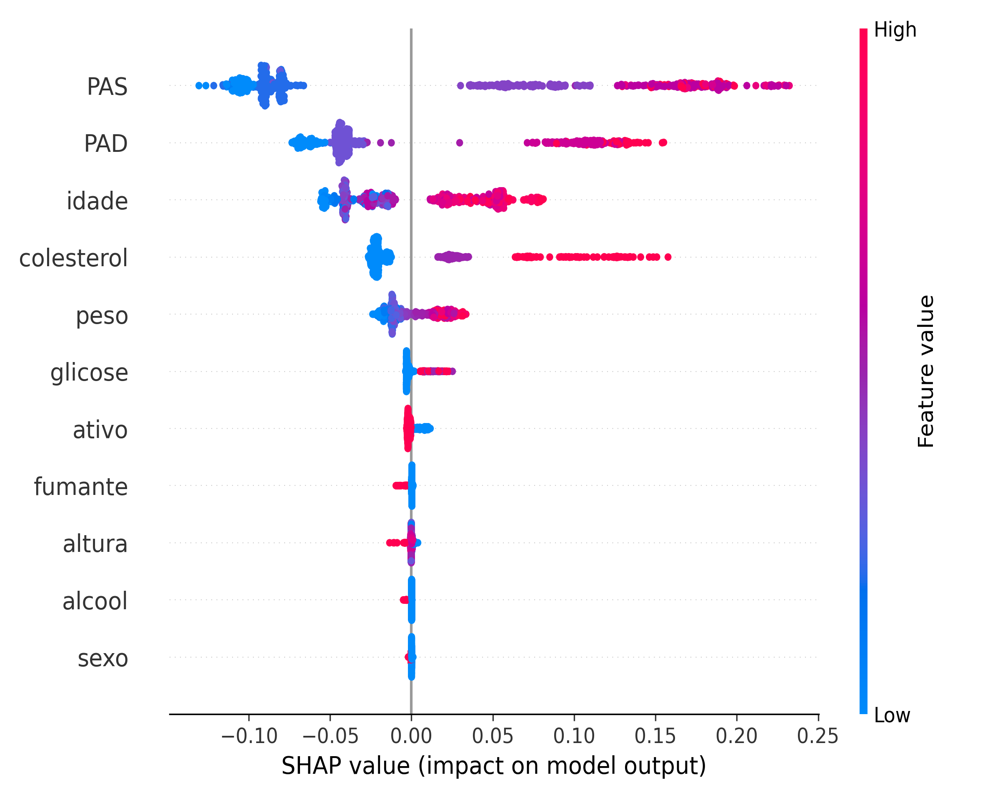

In [20]:
# Abrindo a imagem criada acima
img = Image.open("/home/formiga/Desktop/Cardio/summary_plot.png")
img_resized = img.resize((1000, 800))
display(img_resized)

Algumas observações podem ser realizadas a partir da imagem acima:

- A Pressão Arterial Sistólica é a mais eficaz para o modelo, de modo que, com valores altos, o modelo aumenta a probabilidade para a classe 1 e vice-versa.

- Podemos observar uma ampla dispersão para o colesterol, embora o dataset possua apenas 3 valores (normal, acima do normal e muito acima do normal), o que indica que interage diretamente com a coluna cardio.

- A variável de fumo tem pouco impacto quando seu valor é zero, já que a maioria dos dados é zero (91% do dataset). Isso causa uma mudança na variável alvo mesmo quando ela permanece constante. Quando é 1, o modelo reduz a probabilidade de ter a doença. Isso sugere que há mais não fumantes saudáveis do que fumantes doentes nos dados, devido ao pequeno número de fumantes na amostra. O problema se repete para o consumo de álcool (apenas 5%) e a taxa de glicose (15%). Isso tudo foi informado pelo YData e confirmado após a geração do modelo.

In [21]:
# Analisando item a item, ou seja, poderiamos subsituir o n pelo CPF ou RG do paciente, por exemplo.
# Se a barra estiver para a direita (rosa), o paciente foi previsto com a doença cardíaca. 
# Se estiver para a esquerda (azul), ele não possui o problema cardíaco.

n = 3

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][n], x_train.iloc[n])

In [22]:
# Salvando a imagem criada acima

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][n], x_train.iloc[n], show=False, matplotlib=True).savefig("shap.svg", format='svg', dpi=150, bbox_inches='tight')

In [23]:
# Dados do paciente n configurado acima
x_train.iloc[n]

idade          54
sexo            1
altura        157
peso           74
PAS           125
PAD            89
colesterol      1
glicose         1
fumante         0
alcool          0
ativo           1
Name: 3242, dtype: int64

In [24]:
# Saída correta para o paciente acima
y_train.iloc[n]

0

In [25]:
# Mensagem "bonitinha" para o código acima
y_train.iloc[n] == 0
message = "O paciente está doente." if y_train.iloc[n] else "O paciente não está doente."
print(message)

O paciente não está doente.


In [26]:
print("Se o plot de barra for para um lado e a saída correta for outra, significa que nesse caso, o modelo errou o resultado. \n\nLembrando que não é um modelo perfeito, afinal, o desempenho é de apenas", 100*round(accuracy_score(preds , y_test),4),"%")

Se o plot de barra for para um lado e a saída correta for outra, significa que nesse caso, o modelo errou o resultado. 

Lembrando que não é um modelo perfeito, afinal, o desempenho é de apenas 72.38 %


### Resumindo: O projeto é promissor e ainda há margens para ser melhorado. Principalmente se for adicionado novas variáveis (pacientes) que possuam as 3 últimas características importantes para o modelo (fumo, álcool e glicose), e que é amplamente conhecido por ter relação com doenças cardíacas.